Bollinger Bands&copy; are used in trend following strategies.  See https://www.bollingerbands.com for more information.

We use a moving average of the price of a security, and an upper and lower band around this price.  When the price moves above the upper band, we buy and when the price moves below the lower band we sell.

First, lets load some data.  We are going to use a subset of bitcoin 1 minute bars downloaded from [Kaggle](https://www.kaggle.com/mczielinski/bitcoin-historical-data)

For the purposes of this tutorial, we will trade in 5 minute bars instead of 1 minute bars, so lets resample the OHLCV data to 5 minutes


In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import os
from types import SimpleNamespace

import pyqstrat as pq

pq.set_defaults() # Set some display defaults to make dataframes and plots easier to look at

try:
    file_path = os.path.dirname(os.path.realpath(__file__)) + '/../notebooks/support/bitcoin_1min.csv' # If we are running from unit tests
except:
    file_path = '../notebooks/support/bitcoin_1min.csv'
    
prices = pd.read_csv(file_path)

timestamps = pd.to_datetime(prices.date).values
o = prices.o.values
h = prices.h.values
l = prices.l.values
c = prices.c.values
v = prices['v.usd'].values

Lets create a market data object from this data and plot the first day of the bars to see how they look.

Note that the MarketData constructor **takes c as its second argument, not o**.  This is because h, l, o and v are optional, but c is not.

timestamps len: 1001
o len: 1001
h len: 1001
l len: 1001
c len: 1001
v len: 1001
vwap len: 1001
Inferred Frequency: 5.0 minutes


,o,h,l,c,v,date
count,1001,1001,1001,1001,1001,1001
num_missing,0,0,0,0,0,0
pct_missing,0,0,0,0,0,0
min,7873,7889,7831,7878,1425,2018-03-23 12:40:00
max,9006,9020,8970,9006,6.155e+06,2018-03-27 00:00:00


Errors:
Warnings:


,o,h,l,c,v,ret,warning
date,,,,,,,
2018-03-26 22:05:00,7915,8102,7908,8102,1.771e+06,nan,o ret > 10 * std: 0.0019306
2018-03-26 22:10:00,8103,8150,8046,8150,1.361e+06,0.0237,o ret > 10 * std: 0.0019306
2018-03-26 22:00:00,7888,7925,7876,7908,9.338e+04,nan,h ret > 10 * std: 0.0017736
2018-03-26 22:05:00,7915,8102,7908,8102,1.771e+06,0.02233,h ret > 10 * std: 0.0017736
2018-03-26 22:00:00,7888,7925,7876,7908,9.338e+04,nan,c ret > 10 * std: 0.0019519
2018-03-26 22:05:00,7915,8102,7908,8102,1.771e+06,0.02453,c ret > 10 * std: 0.0019519


Time distribution:


<Figure size 432x288 with 0 Axes>

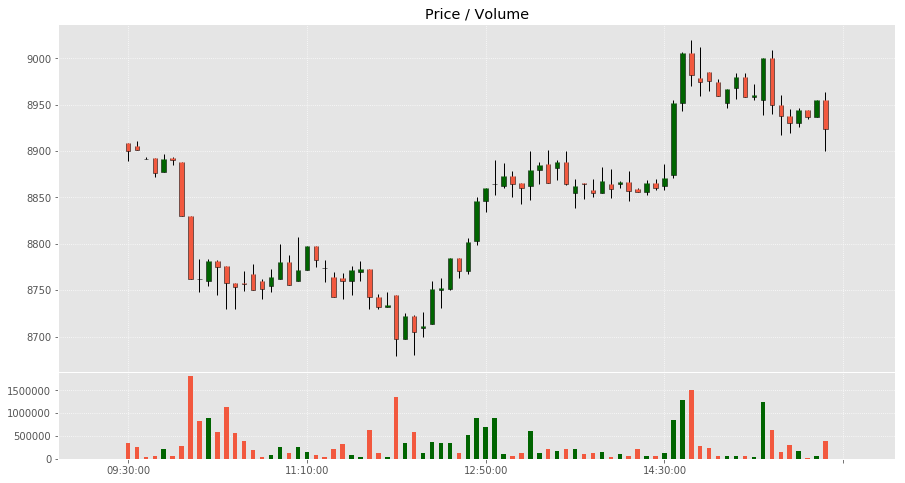

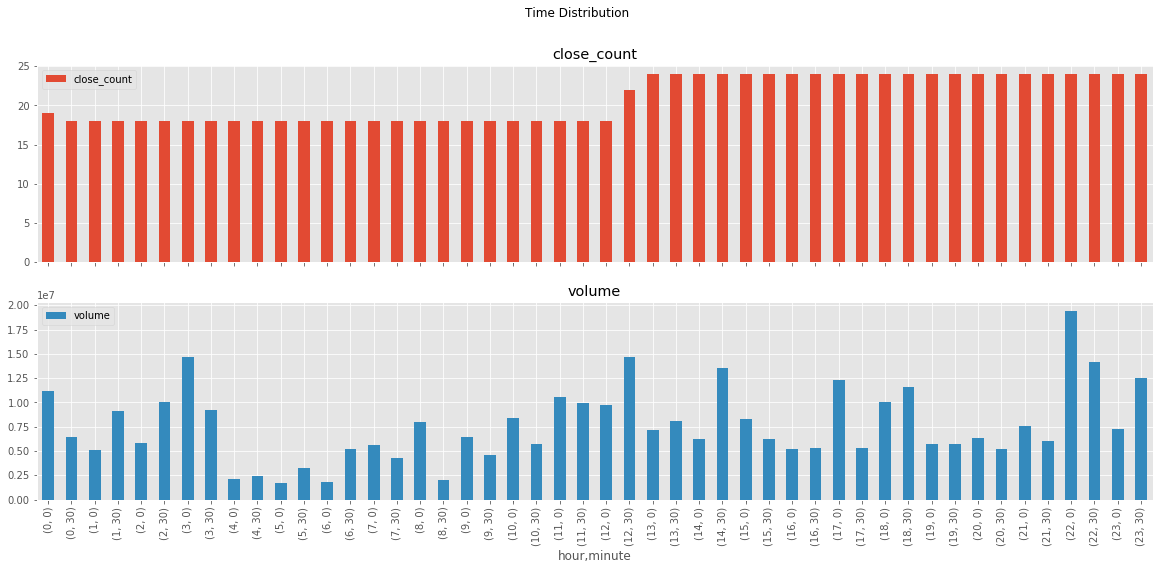

In [2]:
trade_bars = pq.TradeBars(timestamps, c, o, h, l, v)
trade_bars = trade_bars.resample(sampling_frequency='5 min')
trade_bars.plot(date_range = ('2018-03-24 09:30', '2018-03-24 16:00'))
trade_bars.describe(time_distribution_frequency = '30 mins')
timestamps, o, h, l, c = trade_bars.timestamps, trade_bars.o, trade_bars.h, trade_bars.l, trade_bars.c

This looks reasonable.  The describe() function allows us to do some checks on the market data to make sure its ready for use in a strategy.  It tells us:

1.  How much data is missing, and the most common bar frequency.

2.  Errors - Negative values, highs or lows that are lower or higher than opens or closes.

3.  Warnings - Returns for o, h, l, c, v that are more than n (default = 10) standard deviations off the mean.

5.  Time distribution of price frequency and trade volume - This tells you, for example, if the market data includes after-market prices or not.


The next step is to add the Bollinger Bands.  Lets set the middle band as the 20 bar simple moving average of the close, and the upper and lower bands to be 3 standard deviation away from the middle band. This time, instead of plotting candles, we will plot the close price to display a cleaner graph.

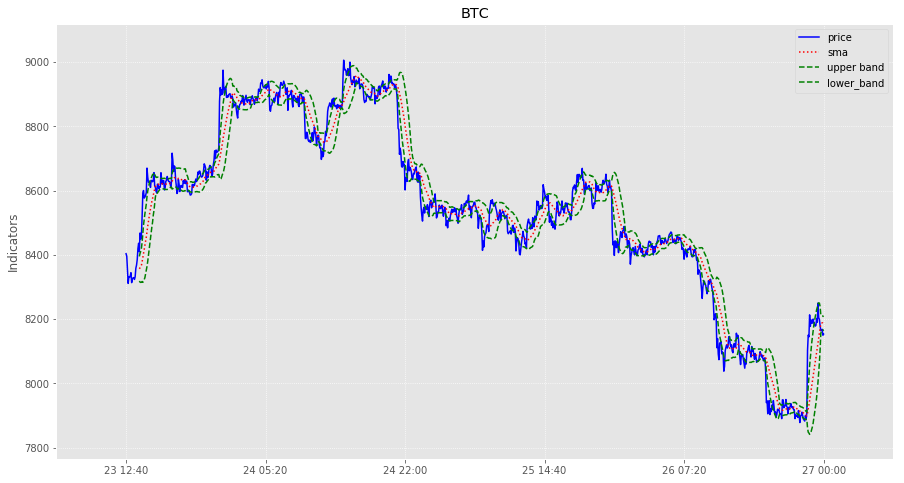

In [3]:
def sma(symbol, timestamps, indicators, strategy_context): # simple moving average
    sma = pd.Series(indicators.c).rolling(window = strategy_context.lookback_period).mean()
    return sma.values

def band(symbol, timestamps, indicators, strategy_context, upper):
    std = pd.Series(indicators.c).rolling(window = strategy_context.lookback_period).std()
    return indicators.sma + strategy_context.num_std * std * (1 if upper else -1)

symbol = 'BTC'
# Each band is 3 standard deviations away from the moving average of price
# Lookback period is 20 bars
strategy_context = SimpleNamespace(num_std = 1, lookback_period = 20)

bb_indicators = SimpleNamespace(o = o, h = h, l = l, c = c)

sma_values = sma(symbol, timestamps, bb_indicators, strategy_context)
bb_indicators.sma = sma_values

upper_band = lambda symbol, timestamps, bb_indicators, strategy_context : \
    band(symbol, timestamps, bb_indicators, strategy_context, upper = True)

lower_band = lambda symbol, timestamps, bb_indicators, strategy_context : \
    band(symbol, timestamps, bb_indicators, strategy_context, upper = False)

upper_band_values = upper_band(symbol, timestamps, bb_indicators, strategy_context)
lower_band_values = lower_band(symbol, timestamps, bb_indicators, strategy_context)

indicator_subplot = pq.Subplot([pq.TimeSeries('price', timestamps, c, color = 'blue'), 
                     pq.TimeSeries('sma', timestamps, sma_values, line_type = 'dotted', color = 'red'),
                     pq.TimeSeries('upper band', timestamps, upper_band_values, line_type = 'dashed', color = 'green'),
                     pq.TimeSeries('lower_band', timestamps, lower_band_values, line_type = 'dashed', color = 'green')],
                     ylabel = 'Indicators')
plot = pq.Plot(indicator_subplot, title = 'BTC')
plot.draw();

The bands and the moving average are called "indicators" in pyqstrat.  Indicators are the fundamental building blocks of any strategy.

Now lets create a signal.  A signal uses marketdata and indicators and tells a strategy when to create orders.  In this case we buy when the price crosses the upper band and exit when the price crosses the moving average.  Similarly, we sell when the price crosses the lower band and exit when it crosses the moving average.  We create 4 different values of the signal, +2, -2, +1, -1 to signal all 4 of these conditions.

In [4]:
def bollinger_band_signal(symbol, timestamps, indicators, parent_signals, strategy_context):
    # Replace nans with 0 so we don't get errors later when comparing nans to floats
    upper_band = np.nan_to_num(indicators.upper_band)
    lower_band = np.nan_to_num(indicators.lower_band)
    sma = np.nan_to_num(indicators.sma)
    
    signal = np.where(indicators.h > upper_band, 2, 0)
    signal = np.where(indicators.l < lower_band, -2, signal)
    signal = np.where((indicators.h > sma) & (signal == 0), 1, signal) # price crossed above simple moving avg but not above upper band
    signal = np.where((indicators.l < sma) & (signal == 0), -1, signal) # price crossed below simple moving avg but not below lower band
    return signal

Let's plot the signal in a subplot along with the indicators and check whether it makes sense

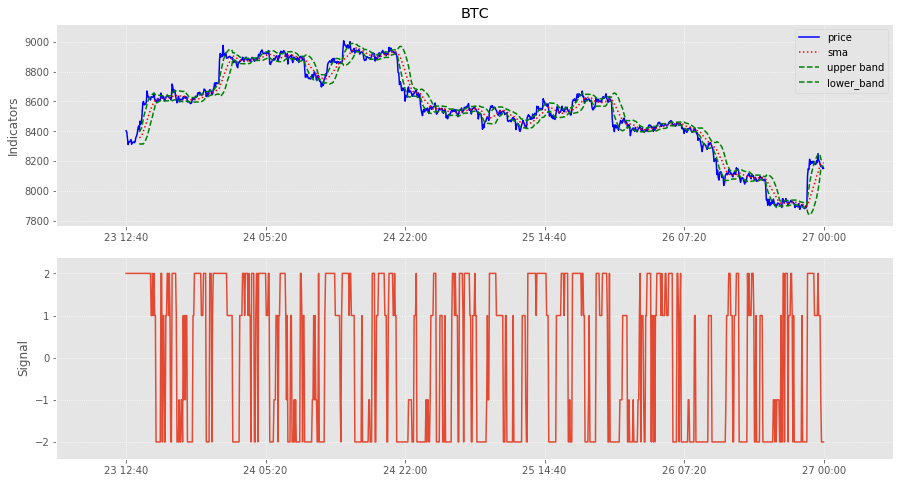

In [5]:
bb_indicators.upper_band = upper_band_values
bb_indicators.lower_band = lower_band_values
bb_indicators.sma = sma_values

signal = bollinger_band_signal('BTC', timestamps, bb_indicators, None, strategy_context)
signal_subplot = pq.Subplot([pq.TimeSeries('signal', timestamps, signal)], ylabel = 'Signal')
plot = pq.Plot([indicator_subplot, signal_subplot], title = 'BTC', show_date_gaps = False)
plot.draw();

This is hard to see clearly so let's look at a smaller date range

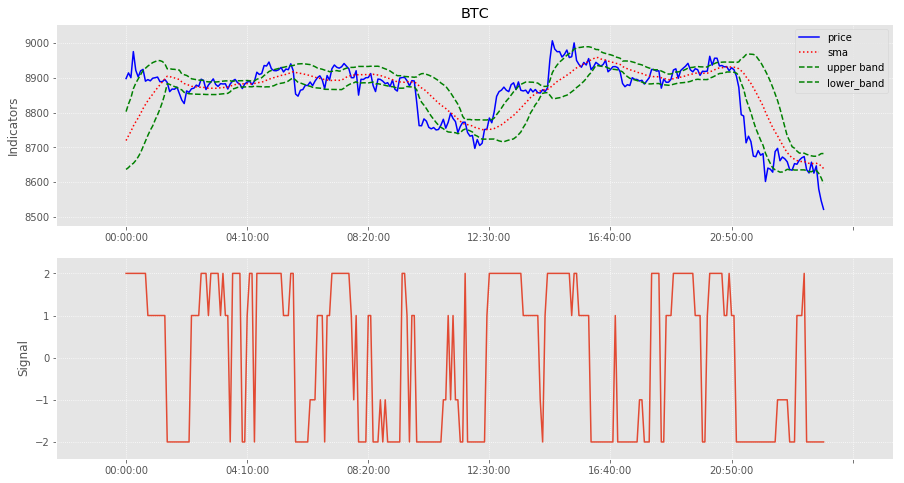

In [6]:
plot = pq.Plot([indicator_subplot, signal_subplot], title = 'BTC', date_range = ('2018-03-24', '2018-03-25'))
plot.draw();

This looks good.  The signal behaves as we would expect.

The next step is to create a trading rule.  pyqstrat will call a trading rule function when the value of it's associated signal changes value, or when we have live orders in the market that have not been filled.  A trading rule decides whether or not to take action on the signal.  If it decides to take action, it returns a list of one or more orders.  This is where margin decisions are made as well, i.e. the trading rule knows how much margin is needed, and will not place orders if margin is exceeded.

Trading rules are usually path dependent, i.e. they cannot be vectorized like indicators and signals can, since can depend on current position, risk, or other data that changes with time.  

Because of this path dependence, pyqstrat will call order rule functions once per date.  This is the part of the code (along with market simulation) that you should optimize as much as you can.  My advice is to use numpy arrays as much as possible here, avoiding slow parts of pandas code.

Lets build the trading rule.  We will risk 10% of our current equity when going long or short.  When entering we will enter a stop order.  This means the system will only enter if the price crosses the current close during the next bar.  We are trying to avoid a case where we cross a bollinger band in this bar but then price immediately goes the other way in the next bar, in which case we should not enter the trade.  We will ignore margin in this case for simplicity.  If we wanted to check margin, we would add code here that would check if margin would be exceeded (based on broker specific logic), and modify the order qty accordingly.

We are using predefined order reason codes when we create orders below.  Reason codes are optional strings that we use to identify why we entered an order and are useful for debugging and for plotting.  You can use an arbitrary string as a reason code.  If you later want to identify those trades in a plot, you will have to provide a mapping between your reason codes and the markers used for that reason code in a trade plot.

In [7]:
def bollinger_band_trading_rule(symbol, i, timestamps, indicators, signal, account, strategy_context):
    timestamp = timestamps[i]
    curr_pos = account.position(symbol, timestamp)
    signal_value = signal[i]
    risk_percent = 0.1
    close_price = indicators.c[i]
    
    # if we don't already have a position, check if we should enter a trade
    if math.isclose(curr_pos, 0):
        if signal_value == 2 or signal_value == -2:
            curr_equity = account.equity(timestamp)
            order_qty = np.round(curr_equity * risk_percent / close_price * np.sign(signal_value))
            trigger_price = close_price
            reason_code = pq.ReasonCode.ENTER_LONG if order_qty > 0 else pq.ReasonCode.ENTER_SHORT
            return [pq.StopLimitOrder(symbol, timestamp, order_qty, trigger_price, reason_code = reason_code)]
        
    else: # We have a current position, so check if we should exit
        if (curr_pos > 0 and signal_value == -1) or (curr_pos < 0 and signal_value == 1):
            order_qty = -curr_pos
            reason_code = pq.ReasonCode.EXIT_LONG if order_qty < 0 else pq.ReasonCode.EXIT_SHORT
            return [pq.MarketOrder(symbol, timestamp, order_qty, reason_code = reason_code)]
    return []


We need to write one more function, a market simulator.  The market simulator decides whether open orders will be filled, and at what price.  This is where you would add slippage, commissions and fees.  You can add a different market simulator for each symbol, since liquidity and market rules are clearly different when trading an IBM stock on NYSE versus trading a E-mini future on CME.  pyqstrat will call the market simulator on the next bar after you add an order since you obviously cannot get filled using prices you already saw and used to construct your order.  In this simulator we fill buy market orders half way between the open and the high for the current bar, and sells half way between the open and the low. Stop orders are filled halfway between the trigger price and the high or low.  Lets assume commission of $5 per contract and no other fees.

In [8]:
def market_simulator(orders, i, timestamps, indicators, signals, strategy_context):
    trades = []
    timestamp = timestamps[i]
    
    o, h, l, c = indicators.o[i], indicators.h[i], indicators.l[i], indicators.c[i]
    
    for order in orders:
        trade_price = np.nan
        
        if isinstance(order, pq.MarketOrder):
            trade_price = 0.5 * (o + h) if order.qty > 0 else 0.5 * (o + l)
        elif isinstance(order, pq.StopLimitOrder):
            if (order.qty > 0 and h > order.trigger_price) or (order.qty < 0 and l < order.trigger_price): # A stop order
                trade_price = 0.5 * (order.trigger_price + h) if order.qty > 0 else 0.5 * (order.trigger_price + l)
        else:
            raise Exception(f'unexpected order type: {order}')
            
        if np.isnan(trade_price): continue
            
        trade = pq.Trade(order.symbol, timestamp, order.qty, trade_price, order = order, commission = order.qty * 5, fee = 0)
        order.status = 'filled'
                           
        trades.append(trade)
                           
    return trades

Now lets create the strategy and run it.

We will instantiate a few objects:


1.  Contract - a symbol represents a real or virtual instrument.  Each contract contains a symbol, marketdata and a multiplier. The multiplier is used in cases where price and quantity are in different units.  For example, for most equity options, a quantity of 1 represents 100 shares, but a price of 0.50 represents 0.50 per share.


2.  Account - an account is tied to a strategy and keeps track of your current equity, realized and unrealized P&L as well as commissions and fees.  An account has a calculation frequency that is usually slower than the strategy.  For example, a strategy may trade with 1 minute bars, but you may only need to calculate P&L at end of day.  However, at some points along the way, you may need intraday equity, etc.  For example, the strategy may need to look at current equity to determine how to size orders.  In these cases, the account will automatically recalculate when you ask it for this data.  An account contains one or more symbols.  In this case we add one symbol, IBM, to the account, and set our starting equity to $1mm.


3.  Strategy - You run a strategy after adding indicators, signals, trading rules, and market simulators to generate orders and trades.  Running a strategy also calculates returns and P&L.


4.  Portfolio - A portfolio is a collection of strategies.  For example, you may have two or more uncorrelated strategies that you want to run concurrently and rebalance periodically.  You can add these to a single portfolio and add rebalance rules to compute returns and P&L.

In [9]:
def get_price(symbol, timestamps, i, strategy_context):
    return c[i]

def build_strategy(contract, strategy_context):
    strategy = pq.Strategy([contract], timestamps, get_price, strategy_context = strategy_context)
    
    strategy.add_indicator('o', o)
    strategy.add_indicator('c', c)
    strategy.add_indicator('h', h)
    strategy.add_indicator('l', l)
    strategy.add_indicator('sma', sma, depends_on = ['c'])
    strategy.add_indicator('upper_band', upper_band, depends_on = ['c', 'sma'])
    strategy.add_indicator('lower_band', lower_band, depends_on = ['c', 'sma'])
    
    strategy.add_signal('bb_signal', bollinger_band_signal, depends_on_indicators = ['h', 'l', 'sma', 'upper_band', 'lower_band'])

    # ask pqstrat to call our trading rule when the signal has one of the values [-2, -1, 1, 2]
    strategy.add_rule('bb_trading_rule', bollinger_band_trading_rule, 
                      signal_name = 'bb_signal', sig_true_values = [-2, -1, 1, 2])

    strategy.add_market_sim(market_simulator, symbols = ['BTC'])
    
    return strategy

strategy_context = SimpleNamespace(lookback_period = 20, num_std = 1)
contract = pq.Contract('BTC', multiplier = 1.)
strategy = build_strategy(contract, strategy_context)

portfolio = pq.Portfolio()
portfolio.add_strategy('bb_strategy', strategy)
portfolio.run()

Lets plot our strategy and our portfolio and evaluate our returns  

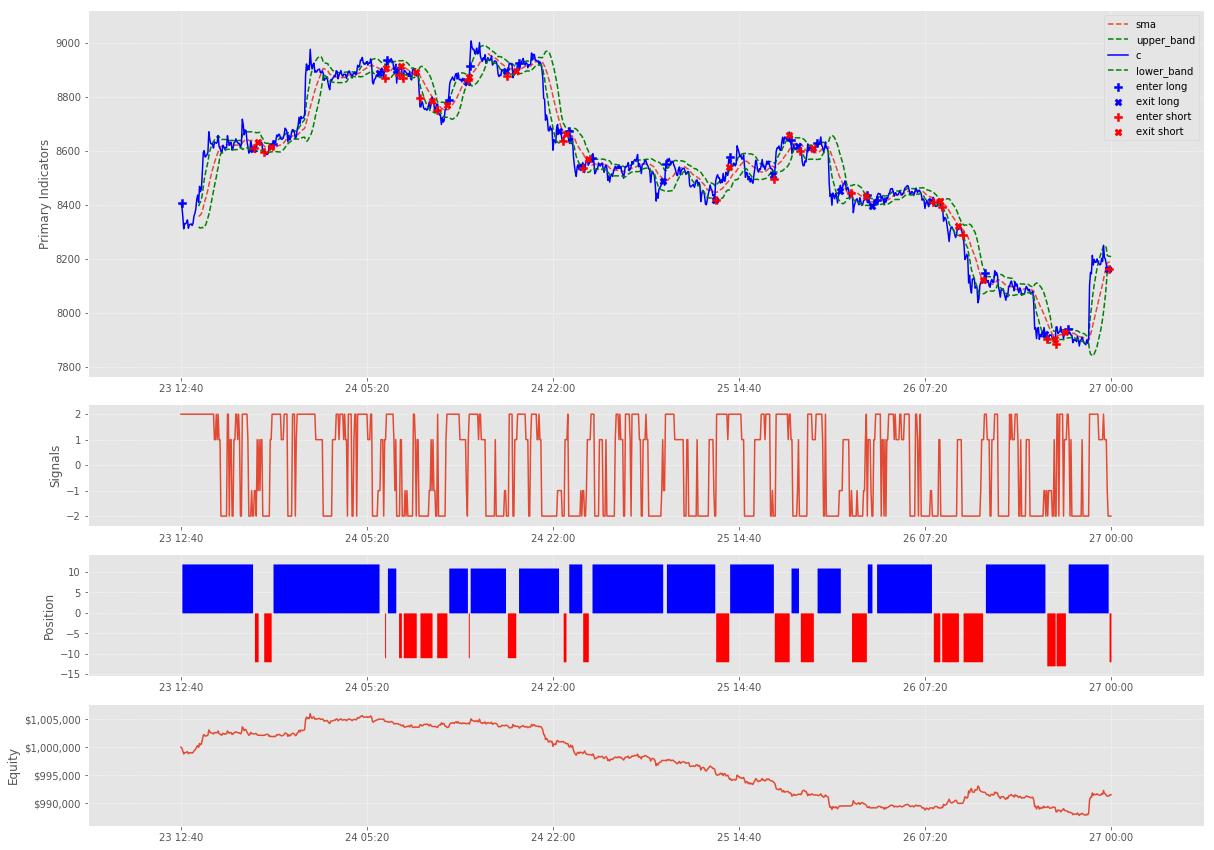

In [10]:
strategy.plot(primary_indicators = ['c', 'sma', 'upper_band', 'lower_band'],
                indicator_properties = {'sma' : {'line_type' : '--'},
                                        'upper_band' : {'line_type' : '--', 'color': 'green'},
                                        'lower_band' : {'line_type' : '--', 'color': 'green'},
                                        'c' : {'color' : 'blue'},
                                       })

In [11]:
strategy.df_returns()

,equity,ret
date,,
2018-03-23,1.005e+06,nan
2018-03-24,9.99e+05,-0.006317
2018-03-25,9.895e+05,-0.009584
2018-03-26,9.915e+05,0.002024


,gmean,amean,std,shrp,srt,calmar,mar,mdd_pct,mdd_dates,dd_3y_pct,dd_3y_timestamps,up_dwn,2018
,-0.5846,-0.003469,0.004683,-11.76,-13.3,55.19,55.19,-0.01584,2018-03-23/2018-03-25,-0.01584,2018-03-23/2018-03-25,1/2/0.333,-0.5846


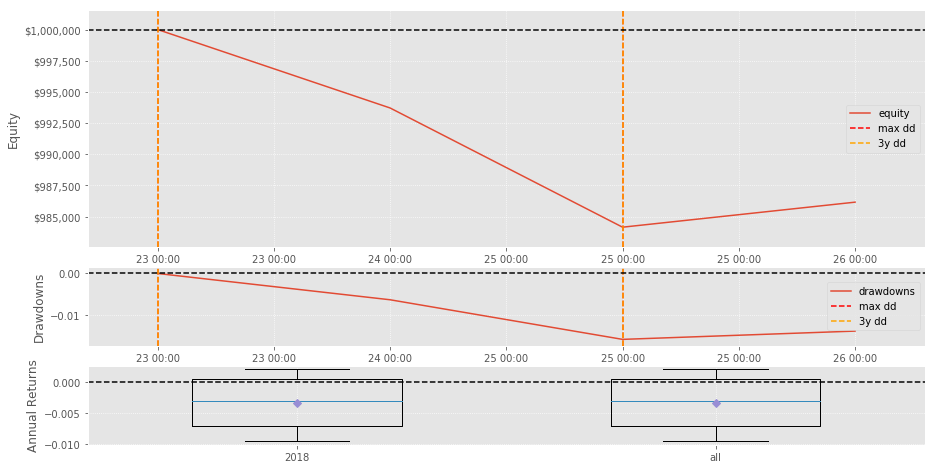

In [12]:
strategy.evaluate_returns();

Note that we calculate P&L once a day so the equity line produced when we evaluate returns has fewer points than the equity line when we plot the strategy itself.

Lets add two to the portfolio and we will run the two strategies together.  We will use two bollinger band strategy with different lookback periods and standard deviations.

In [17]:
from pyqstrat.notebooks.support.build_example_strategy import build_example_strategy


#strategy1 = build_strategy(contract, SimpleNamespace(lookback_period = 5, num_std = 1))
#strategy2 = build_strategy(contract, SimpleNamespace(lookback_period = 10, num_std = 2))


strategy1 = build_example_strategy(lookback_period = 5, num_std = 1)
strategy2 = build_example_strategy(lookback_period = 10, num_std = 2)
portfolio = pq.Portfolio()
portfolio.add_strategy('bb_strategy_1', strategy1)
portfolio.add_strategy('bb_strategy_2', strategy2)
portfolio.run()

#portfolio = pq.Portfolio()
#portfolio.add_strategy('bb_strategy_1', strategy1)
#portfolio.add_strategy('bb_strategy_2', strategy2)
#portfolio.run()

Lets now plot the output of the two strategies as well as the portfolio output.  The portfolio returns will be the sum of the returns of the 2 strategies.

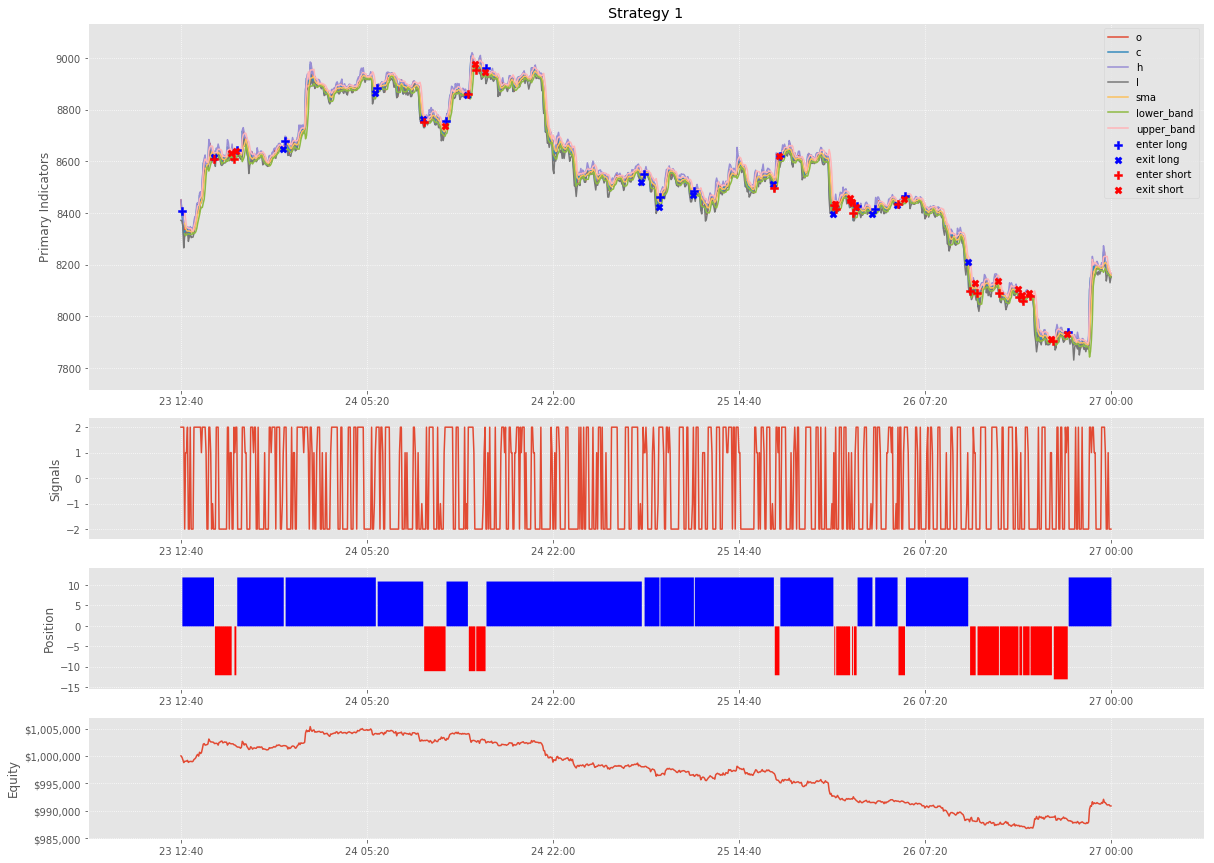

In [19]:
strategy1.plot(title = 'Strategy 1')

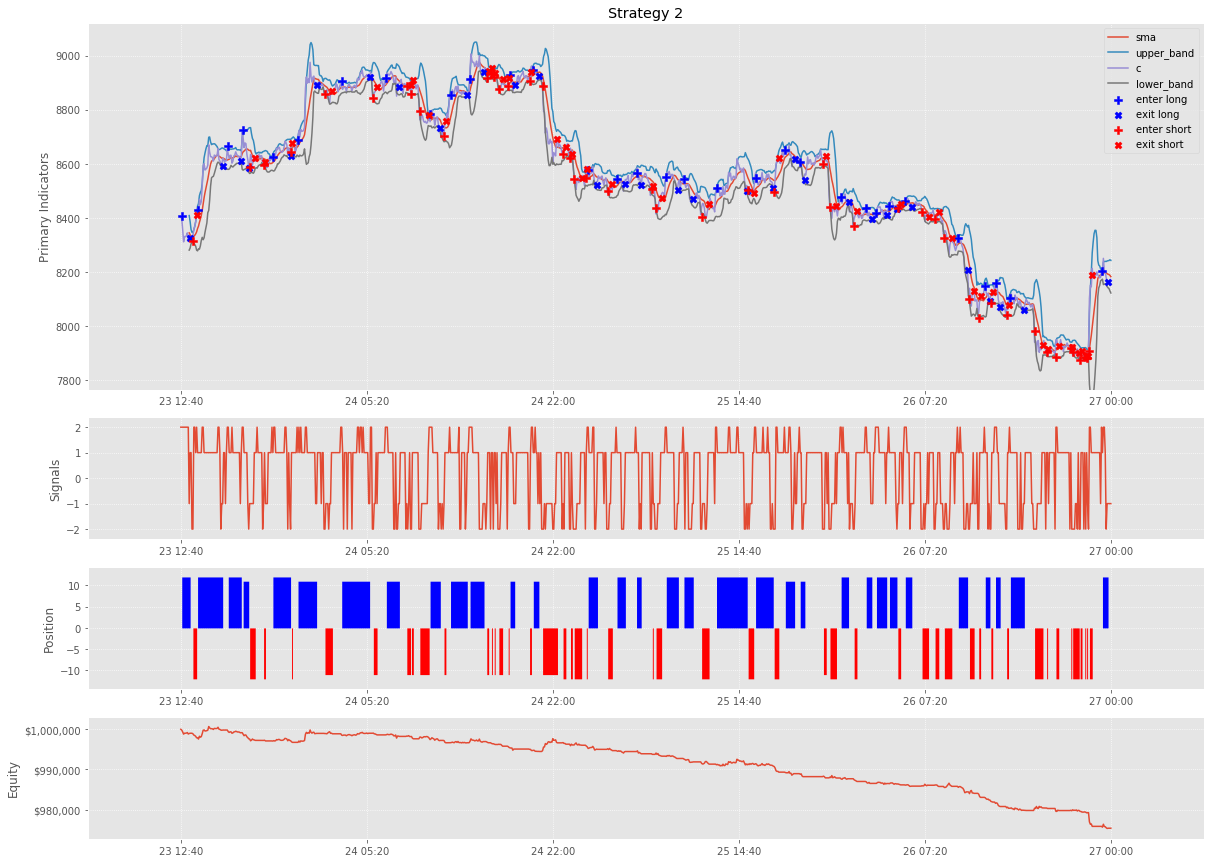

In [21]:
strategy2.plot(title = 'Strategy 2', primary_indicators = ['c', 'sma', 'upper_band', 'lower_band'])

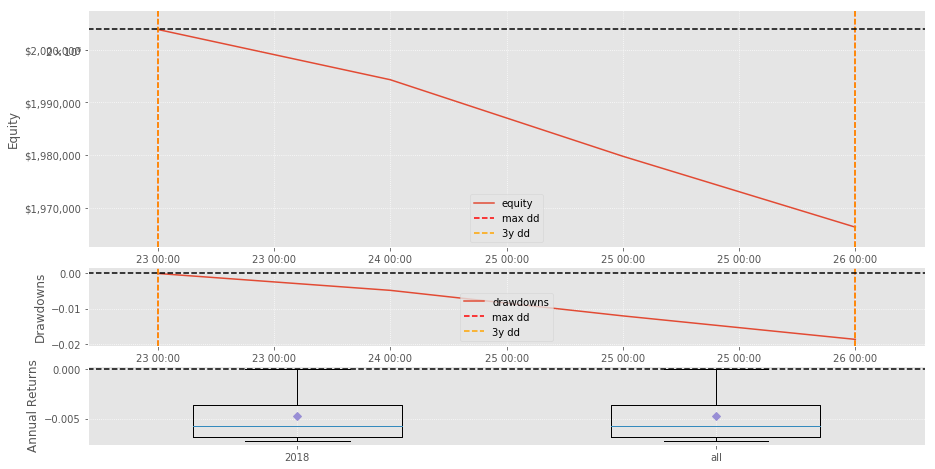

In [18]:
portfolio.plot()